#### Imports

In [9]:
!ls

MURA-v1.1  sample_data


In [3]:
# -*- coding: utf-8 -*-
#!wget -c https://cs.stanford.edu/group/mlgroup/MURA-v1.1.zip
#!unzip MURA-v1.1.zip
#!rm MURA-v1.1.zip
!ls

--2018-12-25 14:17:55--  https://cs.stanford.edu/group/mlgroup/MURA-v1.1.zip
Resolving cs.stanford.edu (cs.stanford.edu)... 171.64.64.64
Connecting to cs.stanford.edu (cs.stanford.edu)|171.64.64.64|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3380245855 (3.1G) [application/zip]
Saving to: ‘MURA-v1.1.zip’

MURA-v1.1.zip       100%[===================>]   3.15G  12.3MB/s    in 4m 18s  

2018-12-25 14:22:13 (12.5 MB/s) - ‘MURA-v1.1.zip’ saved [3380245855/3380245855]

Archive:  MURA-v1.1.zip
   creating: MURA-v1.1/
  inflating: MURA-v1.1/train_labeled_studies.csv  
  inflating: MURA-v1.1/valid_labeled_studies.csv  
  inflating: MURA-v1.1/train_image_paths.csv  
  inflating: MURA-v1.1/valid_image_paths.csv  
   creating: MURA-v1.1/valid/
   creating: MURA-v1.1/valid/XR_ELBOW/
   creating: MURA-v1.1/valid/XR_ELBOW/patient11817/
   creating: MURA-v1.1/valid/XR_ELBOW/patient11817/study1_positive/
 extracting: MURA-v1.1/valid/XR_ELBOW/patient11817/study1_positive/im

In [4]:
# -*- coding: utf-8 -*-
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from os import listdir
from os.path import isfile, join
from tqdm import tqdm
import keras
pd.options.display.max_colwidth = 100
from keras.applications.mobilenetv2 import MobileNetV2
from keras.applications.densenet import DenseNet169
from keras.applications.inception_v3 import InceptionV3
from keras.applications.resnet50 import ResNet50
from keras.applications.nasnet import NASNetLarge
from keras.preprocessing import image
from keras.applications.mobilenetv2 import preprocess_input
from keras.applications import MobileNet
from keras.callbacks import (EarlyStopping, ModelCheckpoint, ReduceLROnPlateau, TensorBoard)
from keras.layers import Dense, GlobalAveragePooling2D, Input
from keras.metrics import binary_accuracy, binary_crossentropy
from keras.models import Model
from keras.optimizers import SGD, Adam
from keras.preprocessing.image import ImageDataGenerator
from keras.applications.mobilenetv2 import MobileNetV2
from keras.preprocessing import image as k_im_prep
from keras.models import Model
from keras import backend as K
from keras.models import Sequential

Using TensorFlow backend.


**Data Reading**

In [0]:
def paths_n_labels(csv,str_limp):
    #make dataframe
    studies=pd.read_csv(csv, sep=',',header=None)
    #separate study paths and labels of given limp from those of other limps
    limp_studies=studies[studies[0].str.contains(str_limp)==True]
    #make it a numpy
    limp_studies=np.array(limp_studies)
    #limp study folder paths
    limp_paths=[]
    #labels of given limp
    limp_labels=[]
    for i in tqdm( range(limp_studies.shape[0]) ):
        study_path=limp_studies[i][0]
        study_label=limp_studies[i][1]
        study_files = [f for f in listdir(study_path) if isfile(join(study_path, f))]
        for image in study_files:
            limp_paths.append(study_path + image)
            limp_labels.append(study_label)

    limp_paths=np.array(limp_paths)
    limp_labels=np.array(limp_labels)

    return limp_paths,limp_labels

In [6]:
studies='MURA-v1.1/valid_labeled_studies.csv'
img_paths,img_labels=paths_n_labels(studies,"WRIST")
#data bias : train
print("\n \n")
print("0 normal, 1 abnormal")
unique, counts = np.unique(img_labels, return_counts=True)
print(dict(zip(unique, counts)))

100%|██████████| 237/237 [00:00<00:00, 15134.28it/s]


 

0 normal, 1 abnormal
{0: 364, 1: 295}


**Read images to memory and preprocessing**

In [0]:
#general function with options for wrist data case, only set wrist_train=True in the case of wrist training data only
#for all other limps and for validation data even that of wrist just pass the paths
#targ_size is image resizing with default(224,224)
#preprocess flag is for using keras preprocessing for images or just resizing
def read_images(paths ,targ_size= (224, 224), wrist_train=False, preprocess=False):
    images=[]
    #load any limp images
    if(not wrist_train):
        for path in tqdm(paths):
            img=k_im_prep.load_img(path, target_size=targ_size )
            if(preprocess):
                img = k_im_prep.img_to_array(img)
                img = np.expand_dims(img, axis=0)
                img = preprocess_input(img)
                images.append(np.array(img)[0])
            else:
              images.append(np.array(img))
    #special case for wrist train corrupted data       
    else:
        #did this because it gave an error at sample  5307 or near it if took all
        sample_e=5307
        sample_s2=5339
        images=[]
        for path in tqdm(paths[:sample_e]):
            img=k_im_prep.load_img(path, target_size=targ_size)
            if(preprocess):
                img = k_im_prep.img_to_array(img)
                img = np.expand_dims(img, axis=0)
                img = preprocess_input(img)
                images.append(np.array(img)[0])
            else:
              images.append(np.array(img))

        #new start
        for path in tqdm(paths[sample_s2:]):
            img=k_im_prep.load_img(path, target_size=targ_size)
            if(preprocess):
                img = k_im_prep.img_to_array(img)
                img = np.expand_dims(img, axis=0)
                img = preprocess_input(img)
                images.append(np.array(img)[0])
            else:
              images.append(np.array(img))

    #making it a numpy array instead of python list
    return (np.array(images))

In [14]:
o=read_images(wrist_paths_val)

s=read_images(wrist_paths_val,preprocess=True)



  3%|▎         | 23/659 [00:00<00:02, 222.91it/s]

(659, 224, 224, 3)



100%|██████████| 659/659 [00:03<00:00, 189.23it/s]

(659, 224, 224, 3)


In [23]:
print(o.shape)
print(s.shape)

(659, 224, 224, 3)
(659, 224, 224, 3)


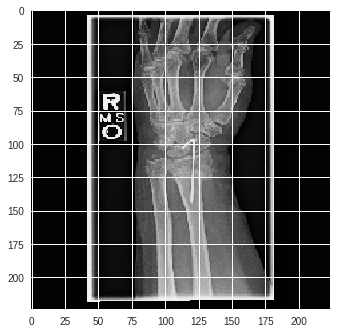

In [18]:
#sample before preprocessing
plt.imshow(o[10])

{-1.0: 414, -0.9921875: 19878, -0.984375: 41562, -0.9765625: 1020, -0.96875: 912, -0.9609375: 1287, -0.953125: 1671, -0.9453125: 1095, -0.9375: 1578, -0.9296875: 2571, -0.921875: 2682, -0.9140625: 2490, -0.90625: 2967, -0.8984375: 3135, -0.890625: 1650, -0.8828125: 741, -0.875: 357, -0.8671875: 156, -0.859375: 135, -0.8515625: 177, -0.84375: 165, -0.8359375: 138, -0.828125: 111, -0.8203125: 159, -0.8125: 165, -0.8046875: 93, -0.796875: 147, -0.7890625: 123, -0.78125: 96, -0.7734375: 147, -0.765625: 117, -0.7578125: 165, -0.75: 198, -0.7421875: 159, -0.734375: 168, -0.7265625: 99, -0.71875: 255, -0.7109375: 267, -0.703125: 264, -0.6953125: 252, -0.6875: 282, -0.6796875: 306, -0.671875: 252, -0.6640625: 279, -0.65625: 318, -0.6484375: 237, -0.640625: 276, -0.6328125: 315, -0.625: 336, -0.6171875: 285, -0.609375: 354, -0.6015625: 402, -0.59375: 372, -0.5859375: 420, -0.578125: 360, -0.5703125: 405, -0.5625: 330, -0.5546875: 384, -0.546875: 348, -0.5390625: 342, -0.53125: 390, -0.5234375: 

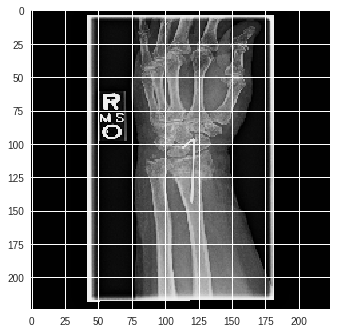

In [27]:
#sample after preprocessing
#must make it between 0 and 1 instead of -1 and 1
plt.imshow((s[10]+1)/2)
unique, counts = np.unique(s[10], return_counts=True)
print(dict(zip(unique, counts)))
unique, counts = np.unique((s[10]+1)/2, return_counts=True)
print(dict(zip(unique, counts)))

#### Training Data

**output is list of paths to images and list of corresponding labels**

In [0]:
#did this because it gave an error at sample  5307 or near it if took all
sample_e=5307
sample_s2=5339

**TODO: handle that unread sample problem**
If couldn't handle it then see how many labels are +ve and how are -ve to have intuition about model results , maybe because too many samples of one class and little of other

In [11]:
#make dataframe
studies=pd.read_csv('MURA-v1.1/train_labeled_studies.csv', sep=',',header=None)
#making a list of paths and a corresponding list of labels
#using non vectorized for speed
#wrist studies
wrist_tr=studies[studies[0].str.contains("WRIST")==True]
wrist_tr=np.array(wrist_tr)

#making a list of paths and a corresponding list of labels
#using non vectorized for speed
wrist_paths_tr=[]
wrist_labels_tr=[]
for i in tqdm( range(wrist_tr.shape[0]) ):
    study_path=wrist_tr[i][0]
    study_label=wrist_tr[i][1]
    study_files = [f for f in listdir(study_path) if isfile(join(study_path, f))]
    for image in study_files:
        wrist_paths_tr.append(study_path + image)
        wrist_labels_tr.append(study_label)

wrist_paths_tr=np.array(wrist_paths_tr)
wrist_labels_tr=np.array(wrist_labels_tr)

print("\n\n")
print(wrist_paths_tr.shape)
print(wrist_labels_tr.shape)


100%|██████████| 3460/3460 [00:00<00:00, 18894.27it/s]




(9756,)
(9756,)


### Todo : issue , images after preprocessing look different

read images from paths to array of images

In [12]:
wrist_images_tr=[]
for path in tqdm(wrist_paths_tr[:sample_e]):
    wrist=k_im_prep.load_img(path, target_size=(224, 224))
    wrist_images_tr.append(np.array(wrist))
#new start
for path in tqdm(wrist_paths_tr[sample_s2:]):
    wrist=k_im_prep.load_img(path, target_size=(224, 224))
    wrist_images_tr.append(np.array(wrist))
#making it a numpy array instead of python list
wrist_images_tr=np.array(wrist_images_tr)

#wrist_labels_tr=wrist_labels_tr[:sample_e]
print("\n\n")
print(wrist_images_tr.shape)
print(wrist_labels_tr.shape)

 49%|████▊     | 2586/5307 [00:10<00:11, 237.35it/s]

KeyboardInterrupt: ignored

In [0]:
start=wrist_labels_tr[:sample_e]
end=wrist_labels_tr[sample_s2:]
wrist_labels_tr=np.hstack([  start, end  ])


In [0]:
print("\n")
print(wrist_images_tr.shape)
print(wrist_labels_tr.shape)
print(start.shape[0]+end.shape[0])

In [0]:
#visualizing random sample after preprocesiing 
index=999
plt.imshow(wrist_images_tr[index])
print(wrist_labels_tr[index])

#### Validation Data

In [13]:
#make dataframe
studies=pd.read_csv('MURA-v1.1/valid_labeled_studies.csv', sep=',',header=None)
#making a list of paths and a corresponding list of labels
#using non vectorized for speed
#wrist studies
wrist_val=studies[studies[0].str.contains("WRIST")==True]
wrist_val=np.array(wrist_val)

#making a list of paths and a corresponding list of labels
#using non vectorized for speed
wrist_paths_val=[]
wrist_labels_val=[]
for i in tqdm( range(wrist_val.shape[0]) ):
    study_path=wrist_val[i][0]
    study_label=wrist_val[i][1]
    study_files = [f for f in listdir(study_path) if isfile(join(study_path, f))]
    for image in study_files:
        wrist_paths_val.append(study_path + image)
        wrist_labels_val.append(study_label)

wrist_paths_val=np.array(wrist_paths_val)
wrist_labels_val=np.array(wrist_labels_val)

wrist_images_val=[]
for path in tqdm(wrist_paths_val):
    wrist=k_im_prep.load_img(path, target_size=(224, 224))
    wrist_images_val.append(np.array(wrist))

wrist_images_val=np.array(wrist_images_val)

print(wrist_images_val.shape)





100%|██████████| 659/659 [00:02<00:00, 235.11it/s]

(659, 224, 224, 3)


In [0]:
#visualizing random sample
index=650
plt.imshow(wrist_images_val[index])
print("label= ",wrist_labels_val[index])

In [0]:
#data bias : train
print("0 normal, 1 abnormal")
unique, counts = np.unique(wrist_labels_tr, return_counts=True)
print(dict(zip(unique, counts)))
#val
unique, counts = np.unique(wrist_labels_val, return_counts=True)
print(dict(zip(unique, counts)))


### Model

In [0]:
def make_FT_model(base=1, imagenet=True, freeze_all=True, add_denses=True):
  
  #weights of pretrained model
  if (imagenet==True):
    w='imagenet'
  else:
    w=None
  
  #initializing pretrained model
  if (base==0):
    base_model = MobileNetV2(input_shape= (224, 224, 3),weights=w, include_top=False)
  elif (base == 1):
    base_model = DenseNet169(input_shape= (224, 224, 3),weights=w, include_top=False)
  elif (base == 2):
    base_model = InceptionV3(input_shape= (224, 224, 3),weights=w, include_top=False)
  elif (base == 3):
    base_model = ResNet50(input_shape= (224, 224, 3),weights=w, include_top=False)   
  elif (base == 4):
    base_model = NASNetLarge(input_shape= (224, 224, 3),weights=w, include_top=False)
    
 
  if (freeze_all):
    #freeze layers of densenet
    for layer in base_model.layers:
      layer.trainable= False 
  
  # add a global spatial average pooling layer
  x = base_model.output
  x = GlobalAveragePooling2D()(x)
  
  if(add_denses):
    # let's add a fully-connected layer
    x = Dense(1024, activation='relu')(x)
    x = Dense(512, activation='relu')(x)
    x = Dense(128, activation='relu')(x)
    x = Dense(32, activation='relu')(x)
    # and a logistic layer -- let's say we have 200 classes
    predictions = Dense(1, activation='sigmoid')(x)
    # this is the model we will train
    model = Model(inputs=base_model.input, outputs=predictions)
    
  else:
    # just feature extractor
    model = Model(inputs=base_model.input, output=x)
  
  
  return model

In [0]:
model=make_FT_model(base=3, imagenet=True, freeze_all=False, add_denses=True)
#m.summary()
#Choose adam or RMSprop ?!
# compile the model (should be done *after* setting layers to non-trainable)
model.compile(optimizer='rmsprop',
              loss='binary_crossentropy',
              metrics=['accuracy'])

model.fit(wrist_images_tr, wrist_labels_tr, epochs=5, validation_data=(wrist_images_val, wrist_labels_val), shuffle=True, verbose=1 )

In [0]:
loss,accuracy=model.evaluate(x=wrist_images_tr, y=wrist_labels_tr, batch_size=128, verbose=1)
print("train loss",loss,"train accuracy",accuracy)

In [0]:
loss,accuracy=model.evaluate(x=wrist_images_val, y=wrist_labels_val, batch_size=128, verbose=1)
print("validation loss",loss,"validation accuracy",accuracy)

** Current point: generalizing functions and code cleaning+ seeing early stopping callback**

All unsolved problems:
* why is it in every epoch the result is the same, all results exactly the same
* which layers to freeze and which to train + should I train TL before freezing it ?
* data augmentation to generate more data
* recording variation in accuracy after every change to get intuition
* no matter Mobilenet,densenet, added or removed denses same results !! exact same even fractions
* the fear of overfitting over validation set
* what does outputted loss represent ? how to read the number ?
* Get more training data through solving the reading problem and getting the remaining 4k images
* normalization step and its effect on accuracy
* should I use 1 or two neurons at output layer ?
* binary crossentropy weights
* justifying parameter use and discovering useful params
* try training with model unfrozen with imagenet and without it
* make a function to record and tabulate outputs
* could we add precision or recall metric ? change accuracy?
* why doesn't it work if removed GlobalAveragePooling line?
* see if want to freeze less layers
* generalize file reading functions
* use better batch size ? increase epochs ?
* training function with preprocessing flag and multiple model comparisons
* grid search like function to tune models and hyperparameters

**results : no preprocessing but resize**


1- Densenet, with imagenet and froze all at rms prop
59% train 55% val

2- Densenet with imagenet and didnt freeze (trained over them)
65% train and 65% validation

2-InceptionV3, with imagenet and froze all at rms prop
59% train 55% val

3-InceptionV3 with imagenet and didnt freeze (trained over them)
82% train and 78% validation